# 4. MLP応用
## 概要
この試験ではChapter04で学習した、深層学習の基礎である多層パーセプトロン(応用)を穴埋め形式で実装します。<br>
予め用意されたコードはそのまま使用し、指示された穴埋め部を編集してください。
試験問題文は<font color="Red">赤字</font>で表示されています。<br>
また、乱数設定により実行結果が異なるため、<font color="Red">コードを完成させたあと、必ずもう一度一番上のセルから順に最後まで実行して結果を確認してください。</font>

所要時間：5~8時間
> テーマ
>> **正則化**: MNIST<br>
>> **データ拡張**: rabbit.jpg<br>
>> [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)を利用します.<br>

### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

使用するライブラリ名とバージョンは配布資料の<font color=Red>「requirements.txt」</font>で確認できます。

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [1]:
import sys

# Google colab環境であるか判定
if "google.colab" in sys.modules:
    # ライブラリのインストール
    %pip install --no-warn-conflicts torch==2.1.1 torchvision==0.16.1
else:
    print("Not Google Colab")

Not Google Colab


### 【Google colabのみ実行】ドライブのマウント

Google Colabでは、**マウント**という作業を行って、Googleドライブ内のファイルを操作できる状態にする必要があります。<br>
<br>
以下のコードを実行してマウントしてください。なお、認証で**Googleアカウントへのログインが必要**になります。

In [2]:
# Google colab環境であるか判定
if "google.colab" in sys.modules:
    # マウントを行う
    from google.colab import drive

    drive.mount("/content/drive")
else:
    print("Not Google Colab")

Not Google Colab


### ライブラリのインポート

必要なライブラリをインポートします。エラーになる場合は該当するものをインストールしてください。

In [3]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
print(torch.cuda.is_available())  # True なら GPU が使える

False


### データの読み込み


In [5]:
root = os.path.join("~", ".torch", "mnist")
transform = transforms.Compose([transforms.ToTensor(), lambda x: x.view(-1)])
mnist_train = datasets.MNIST(
    root="./data", download=True, train=True, transform=transform
)
mnist_test = datasets.MNIST(
    root="./data", download=True, train=False, transform=transform
)

train_dataloader = DataLoader(mnist_train, batch_size=100, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=100, shuffle=False)

## 正則化（PyTorch）

### パラメータノルムペナルティ

ノルムペナルティとは、モデルのパラメータが学習時に極端な値を取らないよう制限をかける手法です。

#### weight decay

weight decayとは、過学習を抑制するための設定です。<br>
損失関数にLpノルムを加算することで、重みパラメータが大きくなりすぎないように抑制することができます。

下記の式のように、損失関数にパラメータのLpノルム$||w||_{p}$を加えます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \lambda||w||_{p}
$$

まずはLpノルム$||w||_{p}$を算出する関数を実装しましょう。また、以下ではテンソルに対するnumpyを用いた演算はエラーが生じる可能性がありますのでtorchを用いた演算を使いましょう。

* <font color="Red">問1. Lpノルムを算出する関数を完成させてください。</font>

In [6]:
def lp_norm(w, p=2):
    """
    Lpノルムを計算する関数
    与えられたベクトルまたはテンソルに対してLpノルム（pノルム）を計算します。

    Args:
        w (Tensor): ノルムを計算するためのベクトルまたはテンソル。
        p (:obj:`int`, optional): ノルムの計算に使用するp値。デフォルトは2（L2ノルム）。

    Returns:
        Tensor: 計算されたノルムの値。

    Examples:
    テンソルのL2ノルムを計算する例：
    >>> w = torch.tensor([1, 2, 3])
    >>> lp_norm(w)
    tensor(3.7417)

    テンソルのL1ノルムを計算する例：
    >>> lp_norm(w, p=1)
    tensor(6.)

    Note:
        この関数はPyTorchライブラリに依存しています。引数 `w` はPyTorchのTensorである必要があります。
    """
    return  (torch.sum(torch.abs(w) ** p)) ** (1 / p) ### 問1 ###

次に、ラッソの損失を算出する関数を実装しましょう。

ラッソの損失はL1ノルムを用いて、下記の式のように定義されます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \lambda\sum_{n=1}^D{|{w_n}|}
$$

L1正則化を行うことで学習を通して重みがスパース（パラメータの多くが0）になります。

* <font color="Red">問2. L1ノルム付き損失関数の</font> $\lambda\sum_{n=1}^D{|w_n|}$ <font color="red">を算出する関数を完成させてください。</font>

In [7]:
def Lasso_loss(net, lam=0.001): #lam:正則化パラメータ
    """
    Lasso損失（L1正則化損失）を計算する関数
    この関数は、与えられたニューラルネットワークモデルのパラメータに対するLasso損失（L1正則化）を計算します。

    Args:
        net (torch.nn.Module): Lasso損失を計算するネットワーク。
        lam (:obj:`float`, optional): L1正則化項の係数。デフォルトは0.001。

    Returns:
        Tensor: 計算されたLasso損失の値。

     Examples:
        ニューラルネットワークモデルのLasso損失を計算する例：

        >>> model = nn.Linear(10, 1)
        >>> Lasso_loss(model, lam=0.01)
        tensor(0.0204)

    Note:
        この関数はPyTorchライブラリに依存しています。引数 `net` はPyTorchの `nn.Module` クラスのインスタンスである必要があります。
    """
    loss = 0
    for name, params in net.named_parameters():#net.named_parameters()はネットワークの各層のパラメータを意味する
        if "bias" not in name: #バイアス項は正則化しない
            loss += torch.sum(torch.abs(params)) ### 問2 ###
    return lam * loss

次に、リッジの損失を算出する関数を実装しましょう。

L2ノルム付き損失関数はL2ノルムの2乗を用いて、下記の式のように定義されます。

$$
L_{norm}(y(X), t) = L(y(X), t) + \frac{\lambda}{2}{\sum_{n=1}^D{w_n^2}}
$$

* <font color="Red">問3.  L2ノルム付き損失関数の</font> $\frac{\lambda}{2}{\sum_{n=1}^D{w_n^2}}$ <font color="red">を算出する関数を完成させてください。</font>

In [8]:
def Ridge_loss(net, lam=0.001):
    """
    Ridge損失（L2正則化損失）を計算する関数
    この関数は、与えられたニューラルネットワークモデルのパラメータに対するRidge損失（L2正則化）を計算します。

    Args:
        net (torch.nn.Module): Ridge損失を計算するネットワーク。
        lam (:obj:`float`, optional): L2正則化項の係数。デフォルトは0.001。

    Returns:
        Tensor: 計算されたRidge損失の値。

    Examples:
        ニューラルネットワークモデルのRidge損失を計算する例：
        >>> model = nn.Linear(10, 1)
        >>> Ridge_loss(model, lam=0.01)
        tensor(0.0148)

    Note:
        この関数はPyTorchライブラリに依存しています。引数 `net` はPyTorchの `nn.Module` クラスのインスタンスである必要があります。
    """
    loss = 0
    for name, params in net.named_parameters():#net.named_parameters()はネットワークの各層のパラメータを意味する
        if "bias" not in name: #バイアス項は正則化しない
            loss += torch.sum(params ** 2) ### 問3 ###
    return (1/2) * lam * loss

## L1/L2正則化を含めたMLPの実装

### 線形結合層などの定義

chapter02,chapter03試験のコードをpytorchを用いて実装しているものであり、読み飛ばしていただいて構いません。

In [9]:
# nn.Linearではなく、スクラッチの際に使用
class FullyConnectedLayer(nn.Module):
    """
    全結層（Fully Connected Layer）を実装するクラス
    このクラスは、ニューラルネットワークにおける基本的な完全連結層（線形層）を実装します。
    入力データの次元数と出力データの次元数を指定して使用します。

    Attributes:
        in_features (int): 層の入力値の次元数。
        out_features (int): 層の出力値の次元数。
        weight (Tensor): 層の重みを表すテンソル。
        bias (Tensor): 層のバイアスを表すテンソル。

    層は、ランダムな初期値を持つ重みとバイアスのパラメータを保持します。
    入力データは、重みに対して行列乗算され、バイアスが加算された後、出力されます。

    Note:
        - このクラスはPyTorchの `nn.Module` を継承しており、PyTorchのフレームワーク内で使用されます。
        - 重みとバイアスはランダムな初期値を持ちます。
    """

    def __init__(self, input_dim, output_dim):
        """
        初期化メソッド
        入力次元数と出力次元数を指定して、完全連結層を初期化します。

        Args:
            input_dim (int): 層の入力値の次元数。
            output_dim (int): 層の出力値の次元数。
        """
        super(FullyConnectedLayer, self).__init__()
        self.in_features = input_dim  # 入力値の次元
        self.out_features = output_dim  # 出力値の次元

        weight = torch.randn(input_dim, output_dim) * 0.01
        bias = torch.randn(output_dim) * 0.01

        self.weight = nn.parameter.Parameter(weight)
        self.bias = nn.parameter.Parameter(bias)

    def forward(self, x):
        """
        順伝播処理：入力データに重みを乗算し、バイアスを加算して出力します。

        Args:
            x (Tensor): 入力データ。

        Returns:
            Tensor: 出力データ。

        Examples:
            >>> fc_layer = FullyConnectedLayer(10, 2)
            >>> input_data = torch.randn(5, 10)
            >>> output_data = fc_layer(input_data)
            >>> print(output_data.shape)
            torch.Size([5, 2])

        Note:
            - このメソッドはPyTorchの `nn.Module` のforwardメソッドをオーバーライドしています。
        """
        x = torch.mm(x, self.weight) + self.bias
        return x

In [10]:
# nn.ReLUではなく、スクラッチの際に使用
class ReLU(nn.Module):
    """
    ReLU（Rectified Linear Unit）活性化関数を実装するクラスです。
    このクラスは、ニューラルネットワークにおいて一般的に使用されるReLU活性化関数を実装します。
    ReLU関数は、入力が0以下の場合は0を出力し、それ以外の場合は入力をそのまま出力します。

    Note:
        このクラスはPyTorchの `nn.Module` を継承しており、PyTorchのフレームワーク内で使用されます。
    """

    def __init__(self):
        """
        初期化メソッド:ReLU層を初期化します。
        """
        super(ReLU, self).__init__()

    def forward(self, x):
        """
        順伝播処理
        入力データにReLU活性化関数を適用します。

        Args:
            x (Tensor): 入力データ。

        Returns:
            Tensor: 活性化後のデータ。

        Examples:
            >>> relu = ReLU()
            >>> input_data = torch.tensor([-1, 0, 1, 2], dtype=torch.float32)
            >>> output_data = relu(input_data)
            >>> print(output_data)
            tensor([0., 0., 1., 2.])

        Note:
            - このメソッドはPyTorchの `nn.Module` のforwardメソッドをオーバーライドしています。
            - 入力が0以下の場合、出力は0になります。
        """
        mask = x <= 0
        x[mask] = 0
        return x

MLPクラスを実装します。<br>
今回構築するモデルのアーキテクチャは以下のようになっています。<br>



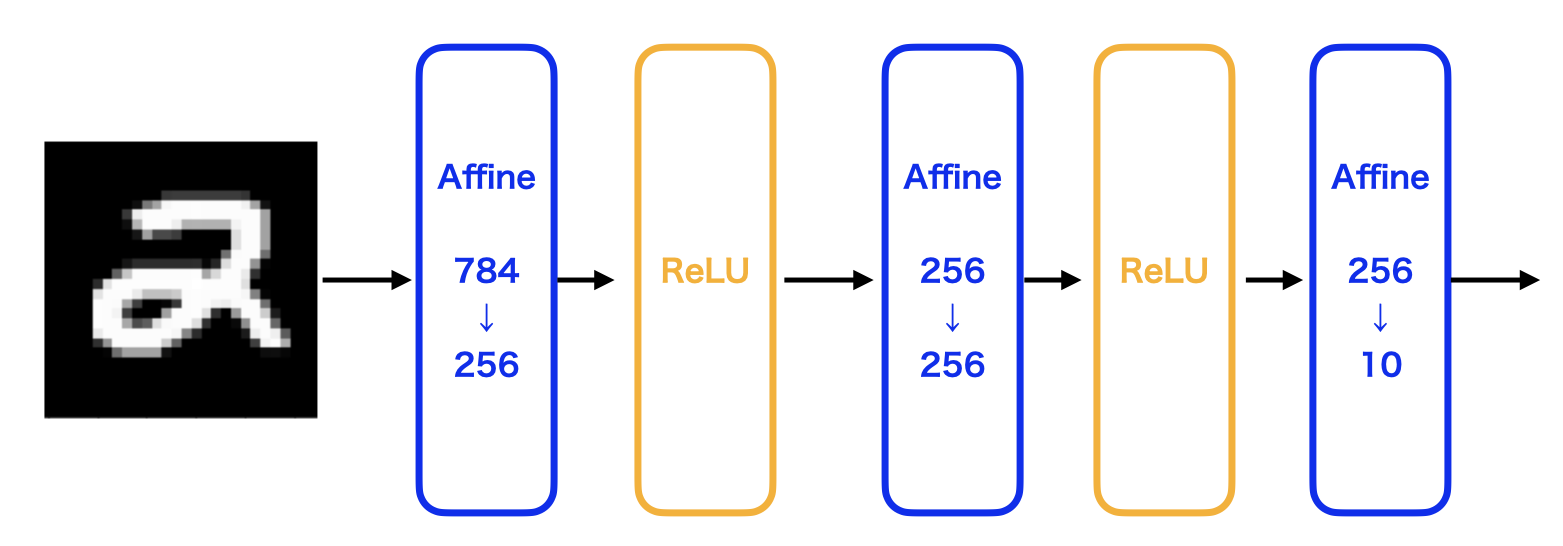

### モデルの定義

In [11]:
class MLP_classifier(nn.Module):
    """多層パーセプトロンベースの分類器
    全結合層とReLU活性化関数を用いて、単純な多層パーセプトロンモデルを実装し、分類タスクに使用されます。
    このモデルは、784次元の入力を受け取り、10クラスに分類する出力を生成します。
    二つの隠れ層を持つ完全連結フィードフォワードネットワークで、各隠れ層の後にはReLU活性化関数が続きます。

    Attributes:
        fc1 (nn.Linear): 入力層から隠れ層への線形変換を行うレイヤー。(784次元から256次元)
        relu1 (nn.ReLU): 第一隠れ層の活性化関数。（ReLU活性化関数）
        fc2 (nn.Linear): 第一隠れ層から第二隠れ層への線形変換を行うレイヤー。(256次元から256次元)
        relu2 (nn.ReLU): 第二隠れ層の活性化関数。（ReLU活性化関数）
        fc3 (nn.Linear): 第二隠れ層から出力層への線形変換を行うレイヤー。(256次元から10次元)

    Note:
        このクラスはPyTorchの `nn.Module` を継承しており、PyTorchのフレームワーク内で使用されます。
    """

    def __init__(self):
        """
        初期化メソッド：各層を初期化し、モデルの構造を定義します。
        構造
        x -> fc(784, 256) -> relu -> fc(256, 256) -> relu -> fc(256, 10) -> x
        """
        super(MLP_classifier, self).__init__()
        # 層の定義
        self.fc1 = nn.Linear(784, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        """
        順伝播処理を行います

        Args:
            x (torch.Tensor): 入力テンソル。

        Returns:
            torch.Tensor: モデルの出力。

        Examples:
            >>> model = MLP_classifier()
            >>> input_tensor = torch.randn(1, 784)
            >>> output = model.forward(input_tensor)
            >>> print(output.size())
            torch.Size([1, 10])
        """
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)

        return x

### 学習
始めに、モデルや損失関数、最適化アルゴリズムを定義します。<br>
また、正則化を適用していない学習ステップとテストステップの手順を関数化します。

In [12]:
# モデルの宣言
model = MLP_classifier()
model.to(device)
# クロスエントロピー(損失関数)を定義
criterion = nn.CrossEntropyLoss()
# 最適化アルゴリズム
optimizer = torch.optim.Adam(model.parameters())


def train_step(x, t, model, optimizer):
    """
    訓練ステップを実行する関数

    Args:
        x (Tensor): 入力データ。
        t (Tensor): 真のラベル。
        model (torch.nn.Module): トレーニングするモデル。
        optimizer (torch.optim.Optimizer): 最適化アルゴリズム。

    Returns:
        tuple(loss): 教師データと予測値から計算された損失
        tuple(preds): モデルの予測値

    Examples:
        >>> model = MLP_classifier()
        >>> optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        >>> x, t = torch.randn(1, 10), torch.tensor([1])
        >>> loss, preds = train_step(x, t, model, optimizer)

    Note:
        この関数はPyTorchライブラリに依存しています。
    """
    model.train()
    preds = model(x)
    loss = criterion(preds, t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds


def test_step(x, t, model):
    """
    テストを実行する関数
    入力データ `x` に対する予測を行い、予測と真のラベル `t` との間の損失を計算します。

    Args:
        x (Tensor): 入力データ。
        t (Tensor): 真のラベル。
        model (torch.nn.Module): 評価するモデル。

    Returns:
        tuple(loss): 教師データと予測値から計算された損失
        tuple(preds): モデルの予測値

    Examples:
        >>> model = MLP_classifier()
        >>> x, t = torch.randn(1, 10), torch.tensor([1])
        >>> loss, preds = test_step(x, t, model)

    Note:
        この関数はPyTorchライブラリに依存しています。
    """
    model.eval()
    preds = model(x)
    loss = criterion(preds, t)
    return loss, preds

* <font color="Red">問4. 問3で実装した`Ridge_loss`を使用して、損失関数に正則化項$\frac{\lambda}{2}{\sum_{n=1}^D{w_n^2}}$を加えましょう。</font>

また、L2正則化を適用した学習ステップとテストステップの手順を関数化します。

In [13]:
# モデルの宣言
l2_model = MLP_classifier()
l2_model.to(device)
# クロスエントロピー(損失関数)を定義
criterion = nn.CrossEntropyLoss()
# 最適化アルゴリズム
l2_optimizer = torch.optim.Adam(l2_model.parameters())


def compute_ridge_loss(y, t, criterion=criterion, model=l2_model, lam=0.001):
    """
    Ridge損失（L2正則化損失）を含む全体の損失を計算する関数

    この関数は、予測値 `y` と真のラベル `t` の間の損失（通常の損失）と、
    モデルの重みに対するRidge損失（L2正則化損失）を合算して、全体の損失を計算します。

    Args:
        y (Tensor): モデルによる予測値。
        t (Tensor): 真のラベル。
        criterion (function): 通常の損失を計算する関数。
        model (torch.nn.Module): 使用するモデル。
        lam (float, optional): Ridge損失の係数。デフォルトは0.001。

    Returns:
        Tensor: 計算された全体の損失。

    Examples:
        >>> y, t = torch.randn(1, 10), torch.tensor([1])
        >>> loss = compute_ridge_loss(y, t, model=model, lam=0.001)

    Note:
        この関数はPyTorchライブラリに依存しています。
    """
    l2_loss = criterion(y, t)
    loss = l2_loss + Ridge_loss(model, lam=lam) ### 問４ ###
    return loss


def train_step_ridge(x, t, model, optimizer, lam=0.001):
    """
    Ridge損失を使用した訓練ステップを実行する関数

    モデルをトレーニングモードに設定し、入力データ `x` に対する予測を行います。
    その後、Ridge損失を含む全体の損失を計算し、最適化手順を実行してモデルの重みを更新します。

    Args:
        x (Tensor): 入力データ。
        t (Tensor): 真のラベル。
        model (torch.nn.Module): トレーニングするモデル。
        optimizer (torch.optim.Optimizer): 最適化アルゴリズム。
        lam (float, optional): Ridge損失の係数。デフォルトは0.001。

    Returns:
        tuple(loss): 教師データと予測値から計算された損失
        tuple(preds): モデルの予測値

    Examples:
        >>> model = MLP_classifier()
        >>> optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        >>> x, t = torch.randn(1, 10), torch.tensor([1])
        >>> loss, preds = train_step_ridge(x, t, model, optimizer, lam=0.001)

    Note:
        この関数はPyTorchライブラリに依存しています。
    """
    model.train()
    preds = model(x)
    loss = compute_ridge_loss(preds, t, lam=lam)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds


def test_step_ridge(x, t, model, lam=0.001):
    """
    Ridge損失を使用したテストステップを実行する関数

    モデルを評価モードに設定し、入力データ `x` に対する予測を行います。
    その後、Ridge損失を含む全体の損失を計算します。この関数では、モデルの重みは更新されません。

    Args:
        x (Tensor): 入力データ。
        t (Tensor): 真のラベル。
        model (torch.nn.Module): 評価するモデル。
        lam (float, optional): Ridge損失の係数。デフォルトは0.001。

    Returns:
        tuple(loss): 教師データと予測値から計算された損失
        tuple(preds): モデルの予測値

    Examples:
        >>> model = MLP_classifier()
        >>> x, t = torch.randn(1, 10), torch.tensor([1])
        >>> loss, preds = test_step_ridge(x, t, model, lam=0.001)

    Note:
        この関数はPyTorchライブラリに依存しています。
    """
    model.eval()
    preds = model(x)
    loss = compute_ridge_loss(preds, t, lam=lam)
    return loss, preds

* <font color="Red">問5. 問2で実装した`Lasso_loss`を使用して、損失関数に正則化項${\lambda}{\sum_{n=1}^D{|w_n|}}$を加えましょう。</font>

また、L1正則化を適用した学習ステップとテストステップの手順を関数化します。

In [14]:
# モデルの宣言
l1_model = MLP_classifier()
l1_model.to(device)
# クロスエントロピー(損失関数)を定義
criterion = nn.CrossEntropyLoss()
# 最適化アルゴリズム
l1_optimizer = torch.optim.Adam(l1_model.parameters())


def compute_lasso_loss(y, t, criterion=criterion, model=l1_model, lam=0.001):
    """
    lasso損失（L2正則化損失）を含む全体の損失を計算する関数

    この関数は、予測値 `y` と真のラベル `t` の間の損失（通常の損失）と、
    モデルの重みに対するlasso損失（L2正則化損失）を合算して、全体の損失を計算します。

    Args:
        y (Tensor): モデルによる予測値。
        t (Tensor): 真のラベル。
        criterion (function): 通常の損失を計算する関数。
        model (torch.nn.Module): 使用するモデル。
        lam (float, optional): Ridge損失の係数。デフォルトは0.001。

    Returns:
        Tensor: 計算された全体の損失。

    Examples:
        >>> y, t = torch.randn(1, 10), torch.tensor([1])
        >>> loss = compute_lasso_loss(y, t, model=model, lam=0.001)

    Note:
        この関数はPyTorchライブラリに依存しています。
    """
    l1_loss = criterion(y, t)
    loss = l1_loss + Lasso_loss(model, lam=lam) ### 問５ ###
    return loss


def train_step_lasso(x, t, model, optimizer, lam=0.001):
    """
    lasso損失を使用した訓練ステップを実行する関数

    モデルをトレーニングモードに設定し、入力データ `x` に対する予測を行います。
    その後、lasso損失を含む全体の損失を計算し、最適化手順を実行してモデルの重みを更新します。

    Args:
        x (Tensor): 入力データ。
        t (Tensor): 真のラベル。
        model (torch.nn.Module): トレーニングするモデル。
        optimizer (torch.optim.Optimizer): 最適化アルゴリズム。
        lam (float, optional): Ridge損失の係数。デフォルトは0.001。

    Returns:
        tuple(loss): 教師データと予測値から計算された損失
        tuple(preds): モデルの予測値

    Examples:
        >>> model = MLP_classifier()
        >>> optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        >>> x, t = torch.randn(1, 10), torch.tensor([1])
        >>> loss, preds = train_step_lasso(x, t, model, optimizer, lam=0.001)

    Note:
        この関数はPyTorchライブラリに依存しています。
    """
    model.train()
    preds = model(x)
    loss = compute_lasso_loss(preds, t, lam=lam)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss, preds


def test_step_lasso(x, t, model, lam=0.001):
    """
    lasso損失を使用したテストステップを実行する関数

    モデルを評価モードに設定し、入力データ `x` に対する予測を行います。
    その後、lasso損失を含む全体の損失を計算します。この関数では、モデルの重みは更新されません。

    Args:
        x (Tensor): 入力データ。
        t (Tensor): 真のラベル。
        model (torch.nn.Module): 評価するモデル。
        lam (float, optional): lasso損失の係数。デフォルトは0.001。

    Returns:
        tuple(loss): 教師データと予測値から計算された損失
        tuple(preds): モデルの予測値

    Examples:
        >>> model = MLP_classifier()
        >>> x, t = torch.randn(1, 10), torch.tensor([1])
        >>> loss, preds = test_step_lasso(x, t, model, lam=0.001)

    Note:
        この関数はPyTorchライブラリに依存しています。
    """
    model.eval()
    preds = model(x)
    loss = compute_lasso_loss(preds, t, lam=lam)
    return loss, preds

最初に正則化を行わない状態で学習ステップ`train_step`、テストステップ`test_step`を用いて学習と評価を行います

<!-- <font color="red">問0. これより下に問題はありません</font> -->

In [15]:
# 損失,精度,重みを記録するためのリストを追加
train_losses = []
train_accs = []
test_losses = []
test_accs = []
# no_reg_weights = []
avg_fc1_weights = []

# 学習エポック数
epochs = 15
# epochs繰り返す
for epoch in range(epochs):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
    fc1_weights = []  # fc1層の重みを保存するリスト

    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = train_step(imgs, labels, model, optimizer)
        train_loss += loss.item()
        train_acc += torch.sum(torch.argmax(preds, axis=1) == labels)
        fc1_weights.append(model.fc1.weight.detach().cpu().numpy())
    train_loss /= len(train_dataloader)
    train_acc /= len(mnist_train)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    avg_fc1_weight = np.mean(fc1_weights, axis=0)
    avg_fc1_weights.append(avg_fc1_weight)

    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = test_step(imgs, labels, model)
        test_loss += loss.item()
        test_acc += torch.sum(torch.argmax(preds, axis=1) == labels)
    test_loss /= len(test_dataloader)
    test_acc /= len(mnist_test)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(
        f"epoch: {epoch+1}, train loss: {train_loss:.5f}, train acc: {train_acc:.5f}, test loss: {test_loss:.5f}, test acc: {test_acc:.5f}"
    )

epoch: 1, train loss: 0.29880, train acc: 0.91647, test loss: 0.13823, test acc: 0.95880
epoch: 2, train loss: 0.11344, train acc: 0.96583, test loss: 0.09891, test acc: 0.97000
epoch: 3, train loss: 0.07427, train acc: 0.97718, test loss: 0.08541, test acc: 0.97390
epoch: 4, train loss: 0.05299, train acc: 0.98347, test loss: 0.08405, test acc: 0.97440
epoch: 5, train loss: 0.04152, train acc: 0.98635, test loss: 0.07303, test acc: 0.97730
epoch: 6, train loss: 0.03194, train acc: 0.98953, test loss: 0.07494, test acc: 0.97690
epoch: 7, train loss: 0.02507, train acc: 0.99230, test loss: 0.07313, test acc: 0.97870
epoch: 8, train loss: 0.01985, train acc: 0.99368, test loss: 0.07525, test acc: 0.97940
epoch: 9, train loss: 0.01758, train acc: 0.99433, test loss: 0.09612, test acc: 0.97640
epoch: 10, train loss: 0.01738, train acc: 0.99408, test loss: 0.08924, test acc: 0.97830
epoch: 11, train loss: 0.01133, train acc: 0.99625, test loss: 0.09378, test acc: 0.97790
epoch: 12, train lo

次に、損失関数にL1正則化を加えた状態で学習ステップ`train_step_lasso`、テストステップ`test_step_lasso` を用いて評価を行います

In [16]:
# 損失と精度を記録するためのリストを追加
train_lasso_losses = []
train_lasso_accs = []
test_lasso_losses = []
test_lasso_accs = []
lasso_avg_fc1_weights = []

lam = 0.001  # L1 regularization strength

# epochs繰り返す
for epoch in range(epochs):
    train_lasso_loss = 0.0
    test_lasso_loss = 0.0
    train_lasso_acc = 0.0
    test_lasso_acc = 0.0
    lasso_fc1_weights = []  # fc1層の重みを保存するリスト

    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = train_step_lasso(
            imgs, labels, l1_model, l1_optimizer, lam=lam
        )  # Pass lam parameter to train_step
        train_lasso_loss += loss.item()
        train_lasso_acc += torch.sum(torch.argmax(preds, axis=1) == labels)
        lasso_fc1_weights.append(l1_model.fc1.weight.detach().cpu().numpy())

    train_lasso_loss /= len(train_dataloader)
    train_lasso_acc /= len(mnist_train)
    train_lasso_losses.append(train_lasso_loss)
    train_lasso_accs.append(train_lasso_acc)

    lasso_avg_fc1_weight = np.mean(lasso_fc1_weights, axis=0)
    lasso_avg_fc1_weights.append(lasso_avg_fc1_weight)

    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = test_step_lasso(
            imgs, labels, l1_model, lam=lam
        )  # Pass lam parameter to test_step
        test_lasso_loss += loss.item()
        test_lasso_acc += torch.sum(torch.argmax(preds, axis=1) == labels)
    test_lasso_loss /= len(test_dataloader)
    test_lasso_acc /= len(mnist_test)
    test_lasso_losses.append(test_lasso_loss)
    test_lasso_accs.append(test_lasso_acc)

    print(
        f"epoch: {epoch+1}, train loss: {train_lasso_loss:.5f}, train acc: {train_lasso_acc:.5f}, test loss: {test_lasso_loss:.5f}, test acc: {test_lasso_acc:.5f}"
    )

epoch: 1, train loss: 1.37039, train acc: 0.83912, test loss: 0.91143, test acc: 0.89090
epoch: 2, train loss: 0.84125, train acc: 0.89813, test loss: 0.76542, test acc: 0.90860
epoch: 3, train loss: 0.74738, train acc: 0.90902, test loss: 0.71205, test acc: 0.91090
epoch: 4, train loss: 0.68713, train acc: 0.91715, test loss: 0.64930, test acc: 0.92400
epoch: 5, train loss: 0.64646, train acc: 0.92162, test loss: 0.61879, test acc: 0.92640
epoch: 6, train loss: 0.61931, train acc: 0.92393, test loss: 0.59394, test acc: 0.93000
epoch: 7, train loss: 0.59493, train acc: 0.92738, test loss: 0.57621, test acc: 0.93230
epoch: 8, train loss: 0.57826, train acc: 0.92967, test loss: 0.55761, test acc: 0.93380
epoch: 9, train loss: 0.56386, train acc: 0.93202, test loss: 0.54989, test acc: 0.93100
epoch: 10, train loss: 0.55169, train acc: 0.93235, test loss: 0.53605, test acc: 0.93760
epoch: 11, train loss: 0.54106, train acc: 0.93380, test loss: 0.52034, test acc: 0.93960
epoch: 12, train lo

最後に、損失関数にL2正則化を加えた状態で学習ステップ`train_step_ridge`、テストステップ`test_step_ridge` を用いて評価を行います

In [17]:
# 損失と精度を記録するためのリストを追加
train_ridge_losses = []
train_ridge_accs = []
test_ridge_losses = []
test_ridge_accs = []
ridge_avg_fc1_weights = []

lam = 0.001  # L2 regularization strength

# epochs繰り返す
for epoch in range(epochs):
    train_ridge_loss = 0.0
    test_ridge_loss = 0.0
    train_ridge_acc = 0.0
    test_ridge_acc = 0.0
    ridge_fc1_weights = []  # fc1層の重みを保存するリスト

    for imgs, labels in train_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = train_step_ridge(
            imgs, labels, l2_model, l2_optimizer, lam=lam
        )  # Pass lam parameter to train_step
        train_ridge_loss += loss.item()
        train_ridge_acc += torch.sum(torch.argmax(preds, axis=1) == labels)
        ridge_fc1_weights.append(l2_model.fc1.weight.detach().cpu().numpy())
    train_ridge_loss /= len(train_dataloader)
    train_ridge_acc /= len(mnist_train)
    train_ridge_losses.append(train_ridge_loss)
    train_ridge_accs.append(train_ridge_acc)

    ridge_avg_fc1_weight = np.mean(ridge_fc1_weights, axis=0)
    ridge_avg_fc1_weights.append(ridge_avg_fc1_weight)

    for imgs, labels in test_dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        loss, preds = test_step_ridge(
            imgs, labels, l2_model, lam=lam
        )  # Pass lam parameter to test_step
        test_ridge_loss += loss.item()
        test_ridge_acc += torch.sum(torch.argmax(preds, axis=1) == labels)
    test_ridge_loss /= len(test_dataloader)
    test_ridge_acc /= len(mnist_test)
    test_ridge_losses.append(test_ridge_loss)
    test_ridge_accs.append(test_ridge_acc)

    print(
        f"epoch: {epoch+1}, train loss: {train_ridge_loss:.5f}, train acc: {train_ridge_acc:.5f}, test loss: {test_ridge_loss:.5f}, test acc: {test_ridge_acc:.5f}"
    )

epoch: 1, train loss: 0.40237, train acc: 0.91392, test loss: 0.25964, test acc: 0.94870
epoch: 2, train loss: 0.22756, train acc: 0.96215, test loss: 0.20644, test acc: 0.96670
epoch: 3, train loss: 0.19635, train acc: 0.97038, test loss: 0.19431, test acc: 0.96770
epoch: 4, train loss: 0.18082, train acc: 0.97440, test loss: 0.19445, test acc: 0.96830
epoch: 5, train loss: 0.17309, train acc: 0.97703, test loss: 0.18140, test acc: 0.97390
epoch: 6, train loss: 0.16765, train acc: 0.97818, test loss: 0.17031, test acc: 0.97650
epoch: 7, train loss: 0.16164, train acc: 0.97978, test loss: 0.17415, test acc: 0.97500
epoch: 8, train loss: 0.15948, train acc: 0.98005, test loss: 0.18459, test acc: 0.97050
epoch: 9, train loss: 0.15594, train acc: 0.98160, test loss: 0.16828, test acc: 0.97630
epoch: 10, train loss: 0.15077, train acc: 0.98278, test loss: 0.16060, test acc: 0.98010
epoch: 11, train loss: 0.15081, train acc: 0.98313, test loss: 0.15860, test acc: 0.97840
epoch: 12, train lo

### 学習結果
- fc1の重みを可視化します。正則化を適用した場合に重みが抑制されていることが確認できます

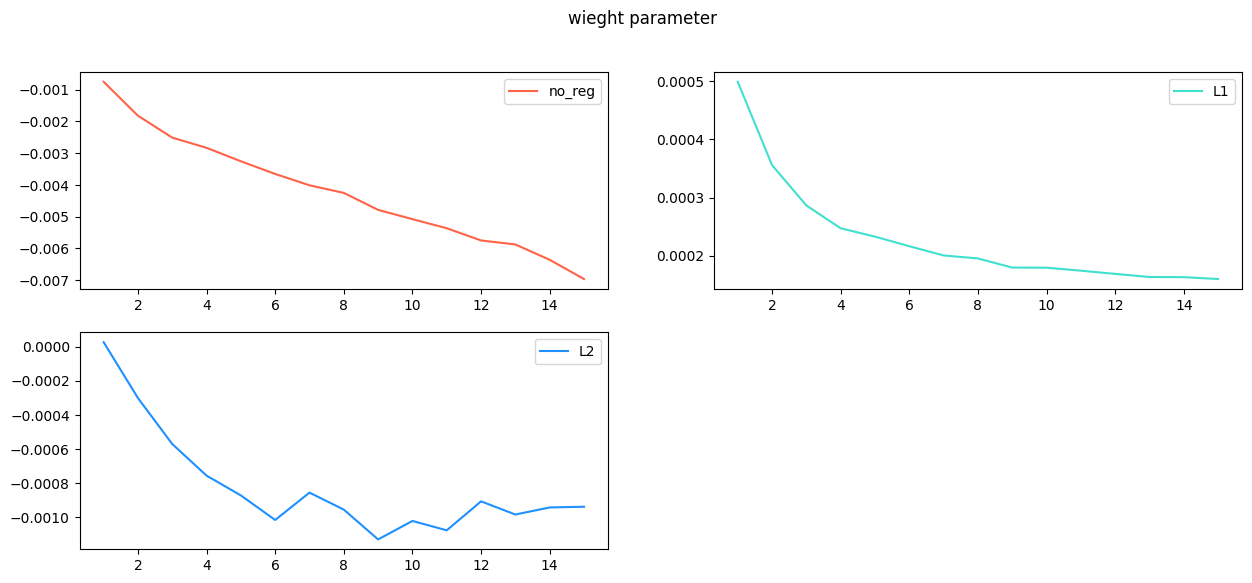

In [18]:
# 正則化なしの結果
no_reg_weights_mean = []
for weights in avg_fc1_weights:
    weight = np.mean(weights.reshape(-1, 1))
    no_reg_weights_mean.append(weight)

# L1正則化の結果
lasso_weights_mean = []
for l1_weights in lasso_avg_fc1_weights:
    l1_weight = np.mean(l1_weights.reshape(-1, 1))
    lasso_weights_mean.append(l1_weight)

# L2正則化の結果
ridge_weights_mean = []
for l2_weights in ridge_avg_fc1_weights:
    l2_weight = np.mean(l2_weights.reshape(-1, 1))
    ridge_weights_mean.append(l2_weight)

# パラメータの推移可視化
fig = plt.figure(figsize=[15, 6.2])
fc1_wieght = fig.add_subplot(2, 2, 1)
l1_wieght = fig.add_subplot(2, 2, 2)
l2_wieght = fig.add_subplot(2, 2, 3)

plt.suptitle("wieght parameter")

fc1_wieght.plot(range(1, epochs + 1), no_reg_weights_mean, color="tomato")
fc1_wieght.legend(["no_reg"])

l1_wieght.plot(range(1, epochs + 1), lasso_weights_mean, color="turquoise")
l1_wieght.legend(["L1"])

l2_wieght.plot(range(1, epochs + 1), ridge_weights_mean, color="dodgerblue")
l2_wieght.legend(["L2"])

- 学習結果を可視化します。正則化を適用した場合に過学習が抑制されていることが確認できます

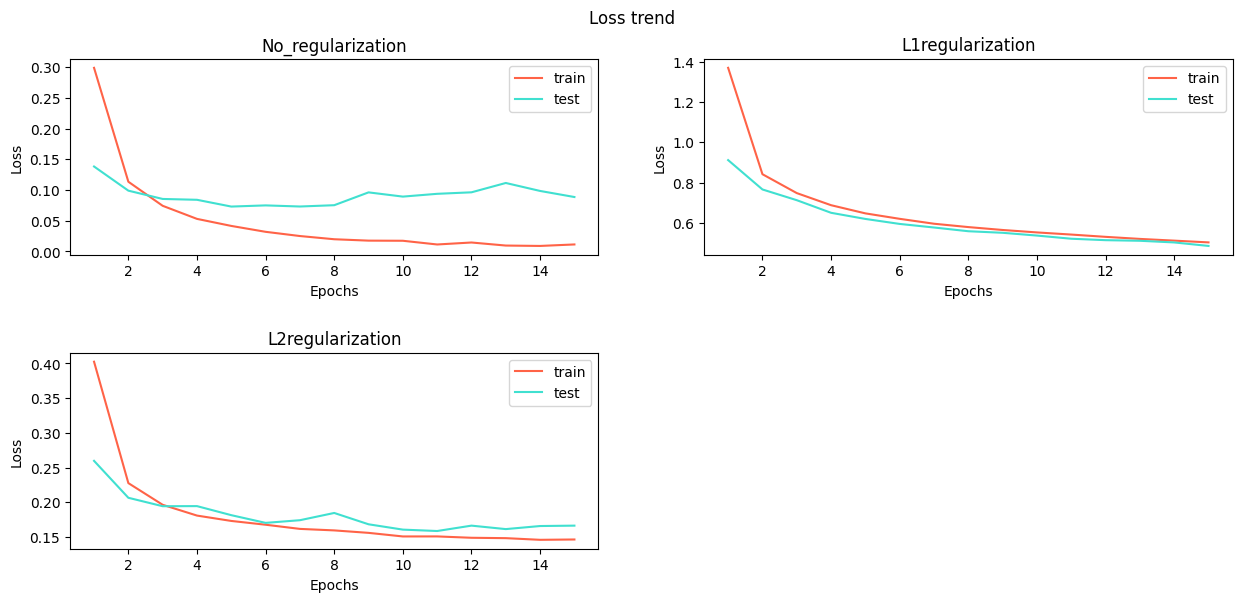

In [19]:
# 過学習抑制の可視化
fig = plt.figure(figsize=[15, 6.2])

no_reg_train = fig.add_subplot(2, 2, 1)
l1_train = fig.add_subplot(2, 2, 2)
l2_train = fig.add_subplot(2, 2, 3)

plt.subplots_adjust(top=0.9, hspace=0.5)
plt.suptitle("Loss trend")

no_reg_train.plot(range(1, epochs + 1), train_losses, color="tomato")
no_reg_train.plot(range(1, epochs + 1), test_losses, color="turquoise")
no_reg_train.set_title("No_regularization")
no_reg_train.set_xlabel("Epochs")
no_reg_train.set_ylabel("Loss")
no_reg_train.legend(["train", "test"])

l1_train.plot(range(1, epochs + 1), train_lasso_losses, color="tomato")
l1_train.plot(range(1, epochs + 1), test_lasso_losses, color="turquoise")
l1_train.set_title("L1regularization")
l1_train.set_xlabel("Epochs")
l1_train.set_ylabel("Loss")
l1_train.legend(["train", "test"])

l2_train.plot(range(1, epochs + 1), train_ridge_losses, color="tomato")
l2_train.plot(range(1, epochs + 1), test_ridge_losses, color="turquoise")
l2_train.set_title("L2regularization")
l2_train.set_xlabel("Epochs")
l2_train.set_ylabel("Loss")
l2_train.legend(["train", "test"])

plt.show()